In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve

# Set path to your dataset in Google Drive
dataset_dir = '/content/drive/MyDrive/de;e/cse412/Augmented_images'  # Update with the correct path

Found 8000 files belonging to 10 classes.
In the dataset, there are 134 files belonging to 10 classes.


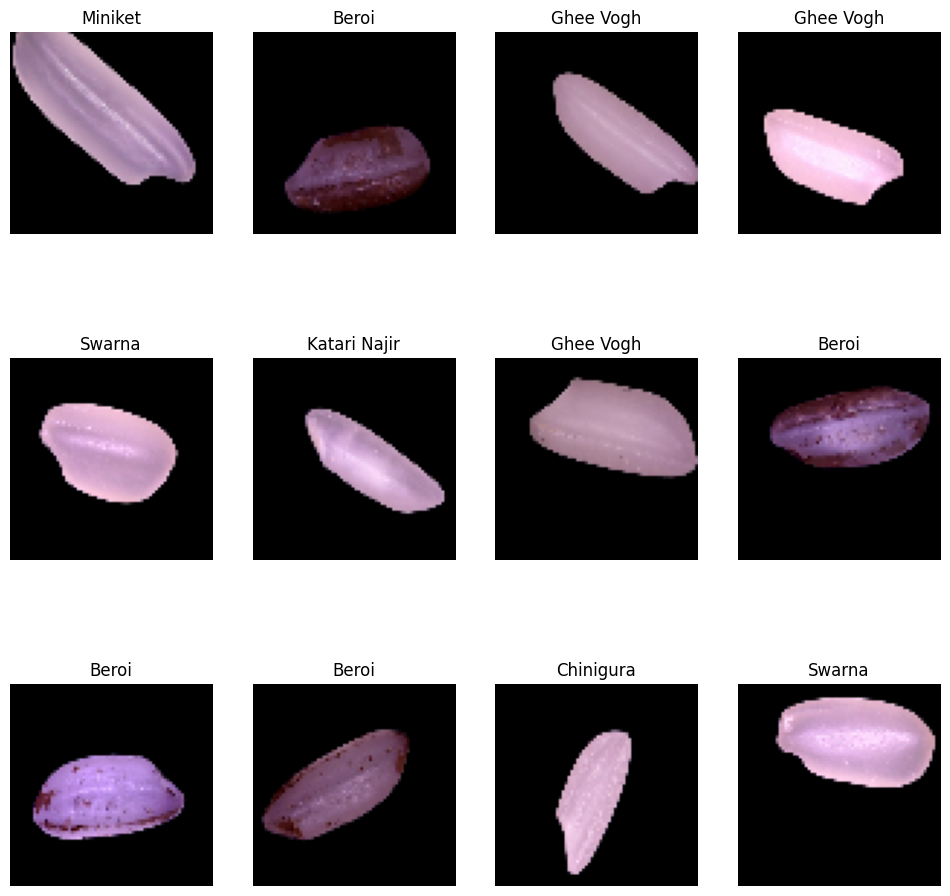

In [4]:

# Set image parameters
IMAGE_SIZE = 70
BATCH_SIZE = 60
CHANNELS = 3
EPOCHS = 100

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(f"In the dataset, there are {len(dataset)} files belonging to {len(class_names)} classes.")

# Display sample images and labels
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Function to partition the dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Prepare the data for training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define the model architecture
#input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)



In [5]:
# Define the model architecture
'''model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Updated to remove 'experimental'
    layers.Rescaling(1.0/255),                # Updated to remove 'experimental'
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(38, activation='softmax'),  # Assuming you have 38 classes
])

model.build(input_shape=input_shape)
'''

"model = models.Sequential([\n    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Updated to remove 'experimental'\n    layers.Rescaling(1.0/255),                # Updated to remove 'experimental'\n    layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),\n    layers.MaxPooling2D((2, 2)),\n    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),\n    layers.MaxPooling2D((2, 2)),\n    layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),\n    layers.MaxPooling2D((2, 2)),\n    layers.Flatten(),\n    layers.Dense(1024, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(1024, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(512, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(512, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(256, activation='relu'),\n    layers.Dropout(0.3),\n    layers.Dense(128, activation='relu'),\n    layers.Dense(38, activation='softmax'),  # Assuming you have 38 classes\n])\n\nmodel.

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, BatchNormalization, Add,
                                     Reshape, Multiply, Conv2D, Concatenate, Lambda)
from tensorflow.keras import backend as K

# CBAM Block Definition
'''def cbam_block(input_tensor, ratio=2):
    channel = K.int_shape(input_tensor)[-1]

    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    max_pool = GlobalMaxPooling2D()(input_tensor)
    shared_dense = Dense(channel // ratio, activation='relu')
    avg_dense = shared_dense(avg_pool)
    max_dense = shared_dense(max_pool)
    channel_attention = Add()([avg_dense, max_dense])
    channel_attention = Dense(channel, activation='sigmoid')(channel_attention)
    channel_attention = Reshape((1, 1, channel))(channel_attention)
    channel_refined = Multiply()([input_tensor, channel_attention])

    # Spatial Attention
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    refined = Multiply()([channel_refined, spatial_attention])

    return refined'''

"def cbam_block(input_tensor, ratio=2):\n    channel = K.int_shape(input_tensor)[-1]\n\n    # Channel Attention\n    avg_pool = GlobalAveragePooling2D()(input_tensor)\n    max_pool = GlobalMaxPooling2D()(input_tensor)\n    shared_dense = Dense(channel // ratio, activation='relu')\n    avg_dense = shared_dense(avg_pool)\n    max_dense = shared_dense(max_pool)\n    channel_attention = Add()([avg_dense, max_dense])\n    channel_attention = Dense(channel, activation='sigmoid')(channel_attention)\n    channel_attention = Reshape((1, 1, channel))(channel_attention)\n    channel_refined = Multiply()([input_tensor, channel_attention])\n\n    # Spatial Attention\n    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_refined)\n    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_refined)\n    concat = Concatenate(axis=-1)([avg_pool, max_pool])\n    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)\n    refined = Multiply

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

# Channel Attention
'''def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True)
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return Multiply()([input_feature, cbam_feature])

# Spatial Attention
def spatial_attention(input_feature):
    kernel_size = 7

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)
    concat = Concatenate(axis=3)([avg_pool, max_pool])

    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)

    return Multiply()([input_feature, cbam_feature])

# CBAM Block
def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

# Custom CNN Model
def customCNN(input_shape, IMAGE_SIZE):
    inputs = layers.Input(shape=input_shape)
    x = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)(inputs)
    x = layers.Rescaling(1.0/255)(x)

    # Block 1
    x = layers.Conv2D(32, (2, 2), activation='relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(64, (2, 2), activation='relu')(x)
    x = cbam_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model
'''

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False


# Full model
model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    #layers.Dropout(0.3),
    #layers.Dense(256, activation='relu'),
    #layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])



input_shape = (70, 70, 3)  # Example
IMAGE_SIZE = 70

#model = customCNN(input_shape, IMAGE_SIZE)
model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 70, 70, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 2, 2, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        19,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,341,194 (69.97 MB)

 Trainable params: 19,210 (75.04 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [8]:

# model = models.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255),
#     layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(2, 2), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(256, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(6, activation='softmax'),  # Assuming you have 38 classes
# ])

# model.build(input_shape=input_shape)


#optimizer = tf.keras.optimizers.SGD(learning_rate=0.006, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.006)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Define callbacks
# checkpoint_path = '/content/drive/MyDrive'  # Update with the desired model path
# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
# )

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
'''early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=30,  # Number of epochs to wait before stopping
    restore_best_weights=True
)'''


#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=1)

'''reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=30,
    verbose=1,
    min_lr=0.0001
)'''

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.75,
    patience=2,
    min_lr=0.00001
)

In [9]:
import os

for subdir, _, files in os.walk("/content/drive/MyDrive/PAPER DATASET/Genitalia1"):
    for file in files:
        path = os.path.join(subdir, file)
        if os.path.getsize(path) == 0:
            print(f"Empty file: {path}")

In [10]:
# Train the model
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[reduce_lr]
    #callbacks=[early_stopping, reduce_lr]
    #callbacks=[early_stopping]
)

# Evaluate the model
scores = model.evaluate(test_ds)
print("Test Loss:", scores[0])
print("Test Accuracy:", scores[1])

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2538s 638ms/step - accuracy: 0.4268 - loss: 1.6938 - val_accuracy: 0.7231 - val_loss: 0.7904 - learning_rate: 0.0010
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7713 - loss: 0.7102 - val_accuracy: 0.7808 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8090 - loss: 0.5695 - val_accuracy: 0.8051 - val_loss: 0.5488 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8326 - loss: 0.5054 - val_accuracy: 0.8295 - val_loss: 0.5155 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8455 - loss: 0.4665 - val_accuracy: 0.8256 - val_loss: 0.5032 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8515 - loss: 0.4254 - val_accuracy: 0.8282 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8664 - loss

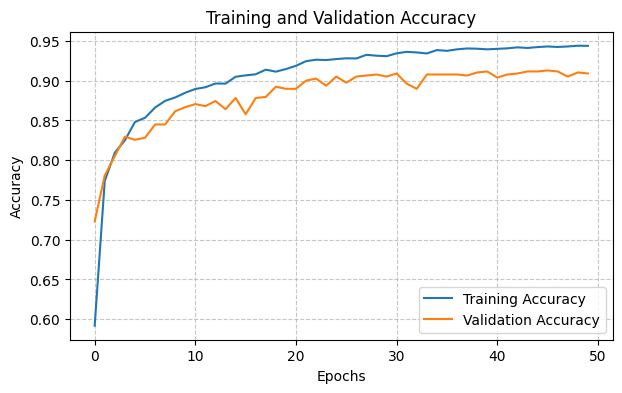

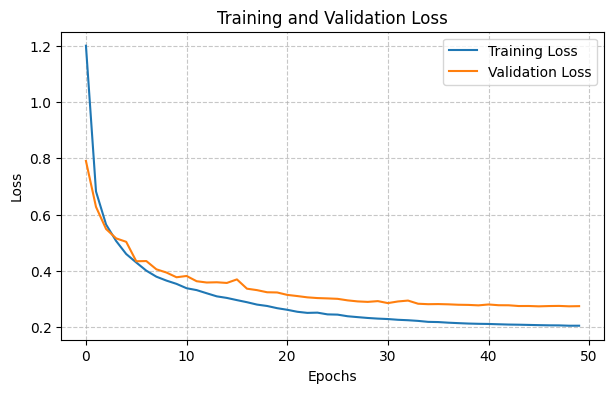

2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 25s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


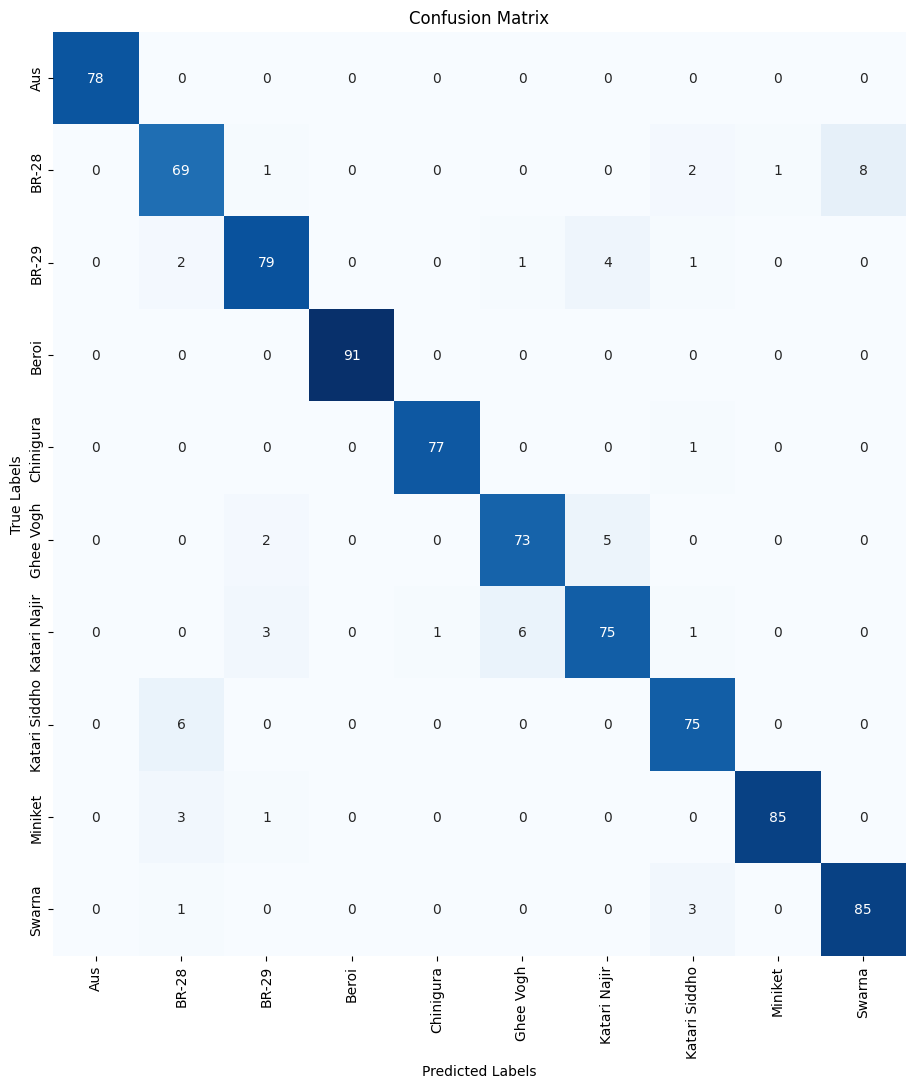


Classification Report:
               precision    recall  f1-score   support

          Aus       1.00      1.00      1.00        78
        BR-28       0.85      0.85      0.85        81
        BR-29       0.92      0.91      0.91        87
        Beroi       1.00      1.00      1.00        91
    Chinigura       0.99      0.99      0.99        78
    Ghee Vogh       0.91      0.91      0.91        80
 Katari Najir       0.89      0.87      0.88        86
Katari Siddho       0.90      0.93      0.91        81
      Miniket       0.99      0.96      0.97        89
       Swarna       0.91      0.96      0.93        89

     accuracy                           0.94       840
    macro avg       0.94      0.94      0.94       840
 weighted avg       0.94      0.94      0.94       840



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Plot the training and validation accuracy
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(7, 4))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Make predictions on the test dataset
y_true = []
y_pred = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    y_true.extend(label_batch.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels

# Generate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(11, 12))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
